# Designing for Availability

As part of the AWS Well-Architected Framework's reliability pillar, there are a number of design principles to remember to help increase your workload's reliability and availability. John is going to focus on these three reliability design principles:

- Automatically recover from failure.
- Scale horizontally to increase aggregate workload availability.
- Stop guessing capacity.

## Availability Zones

Amazon EC2 provides the ability to spread instances across all of the Availability Zones in your Regions. By launching instances in separate Availability Zones, you protect your applications from the failure of any single location. This improves the availability of your workloads in the event of planned or unplanned interruptions. When doing this, ensure that there is an equal distribution of instances across all of the Availability Zones that you are using. The right solution is to equally spread your instances across the Availability Zones that you've chosen to use. If you have 12 instances and 3 zones, you can spread 4 instances in each zone. If 1 zone becomes unavailable, then only 4 instances are impacted. If you have an unequal distribution of instances, such as 8 instances in 1 zone and 2 in each of the other zones, then you run into a situation where, if the zone with the 8 instances is impacted, then the remaining 4 instances might not be enough to provide availability to all of your users. 

One way to ensure that there are always enough instances available to service your customers and that those instances are equally spread across the Availability Zones in your Region is to use Amazon EC2 Auto Scaling.

## Amazon EC2 Auto Scaling 

Amazon EC2 Auto Scaling helps you ensure that you have the correct number of EC2 instances available to handle the load for your application. You can use either the dynamic or predictive scaling policies within EC2 Auto Scaling to add or remove EC2 instances. Predictive scaling uses machine learning to proactively allocate instances based on anticipated demand. With dynamic scaling, you can scale compute based on defined metrics. With EC2 Auto Scaling, you can ensure that the number of EC2 instances you’re using scales up seamlessly during demand spikes to maintain performance and scales down automatically during demand lulls to minimize costs.

You create collections of EC2 instances called Amazon EC2 Auto Scaling groups. You can specify the minimum and maximum number of instances in each group, and EC2 Auto Scaling ensures that your group never goes below or above these sizes. If you specify the desired capacity, either when you create the group or at any time thereafter, EC2 Auto Scaling ensures that your group has that many instances. If you specify scaling policies, then EC2 Auto Scaling can launch or terminate instances as demand on your application increases or decreases.

For example, the following group has a minimum size of one instance, a desired capacity of two instances, and a maximum size of four instances. The scaling policies that you define adjust the number of instances, within your minimum and maximum number of instances, based on the criteria that you specify.

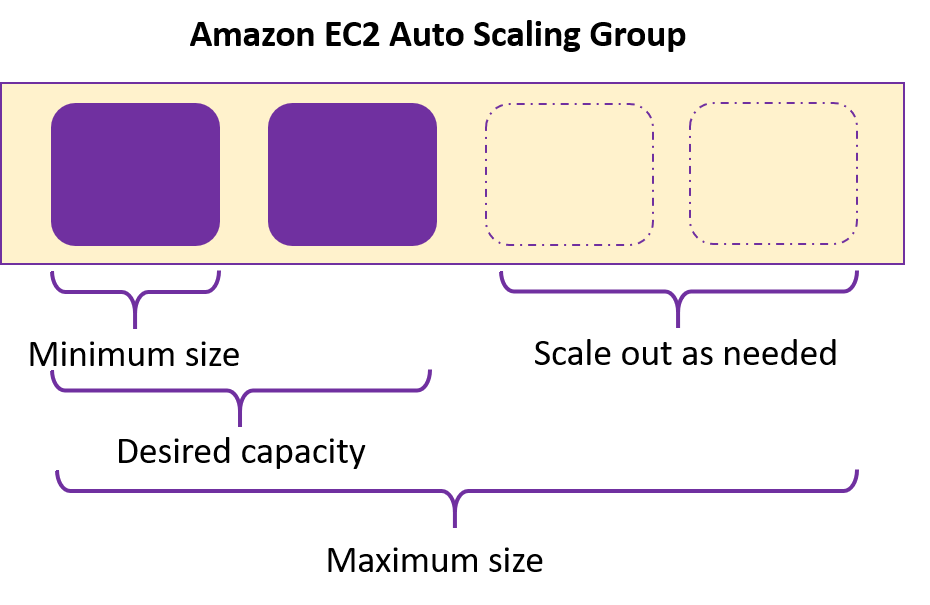



Now that he understands how auto scaling works and how he can increase or decrease his instances based on demand, John needs to address how clients connect to these new multiple instances.

Right now, in John's plan, a client connects and is routed to only a single instance and not to any of the available instances.

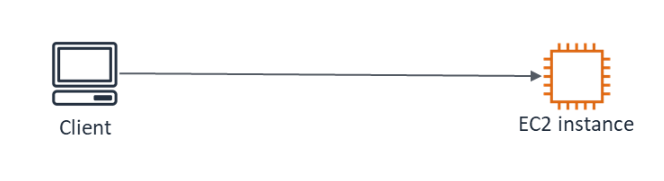

John needs a way to balance the incoming client requests across multiple EC2 instances. He wants to see if there is a way to remove any instance from the group if the instance is not performing well or if it experiences a service disruption. What John needs is a solution like the following image, where a client can be routed to any available instance.

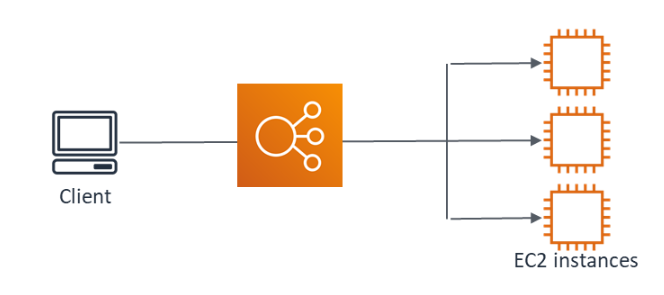



## How to load balance?

John first explores the Elastic IP addresses to see if they will help him route to multiple backend instances. His notes look promising. They say, "An Elastic IP address is allocated to your AWS account and is yours until you release it. By using an Elastic IP address, you can mask the failure of an instance or software by rapidly remapping the address to another instance in your account. Alternatively, you can specify the Elastic IP address in a DNS record for your domain, so that your domain points to your instance."

This sounds promising, but as John researches further, the Elastic IP can only be connected to a Network Load Balancer and not an Application Load Balancer. He realizes that one of these options will provide him with the solution that he's looking for, so he decides to dig deeper into his load balancer options.

## Elastic Load Balancing

Elastic Load Balancing (ELB) automatically distributes incoming application traffic across multiple targets and virtual appliances in one or more Availability Zones.  

ELB supports three types of load balancers.

- Application Load Balancer(opens in a new tab) – If you need to load balance HTTP requests
- Network Load Balancer(opens in a new tab) – For network/transport protocols (TCP, UDP) load balancing and for extreme performance or low latency applications
- Gateway Load Balancer(opens in a new tab) – If you need to deploy and run third-party virtual appliances

ELB improves an application's ability by distribute incoming traffic between two or more EC2 instances. ELB continuously checks the health of the instances. If an instance is unhealthy, ELB will route the traffic to a healthy instance. 

When you combine Elastic Load Balancing with Amazon EC2 Auto Scaling, you can build highly available, fault-tolerant applications that automatically scale capacity up or down based on fluctuations in demand. 

## Store state information outside of your instance

In computing, a cache is a memory area where transient data is held so that future requests for that data are served up faster than is possible by accessing the data’s primary storage location. With caching, you can efficiently reuse previously retrieved or computed data. The state information for a workload can be something as simple as an ecommerce shopping cart or the leaderboard information for a game.

In the plan he is developing, John realizes that he will need some type of caching service so he can store the state information outside of the instances. This will allow the marketing game to display the leaderboard quickly and retain the information should the instances or an Availability Zone become unavailable. John wants the customers to have a good experience with the game and retain their level information, any in-game items they accumulate, and any awarded prizes. He needs to ensure that a user on one instance can seamlessly failover to another instance without a loss of their data. Storing this type of state information outside of the instance is crucial to the seamless failover and quick access to data without having to continually pull the information stored on disk.

John wants to provide a caching solution to keep transient data. He also wants a backend database to store more permanent customer data. John imagines that the layout has two subnets, one public and one private with the EC2 instances sitting in the public subnet and the caching and database solution sitting in the private subnet as shown in the following image.

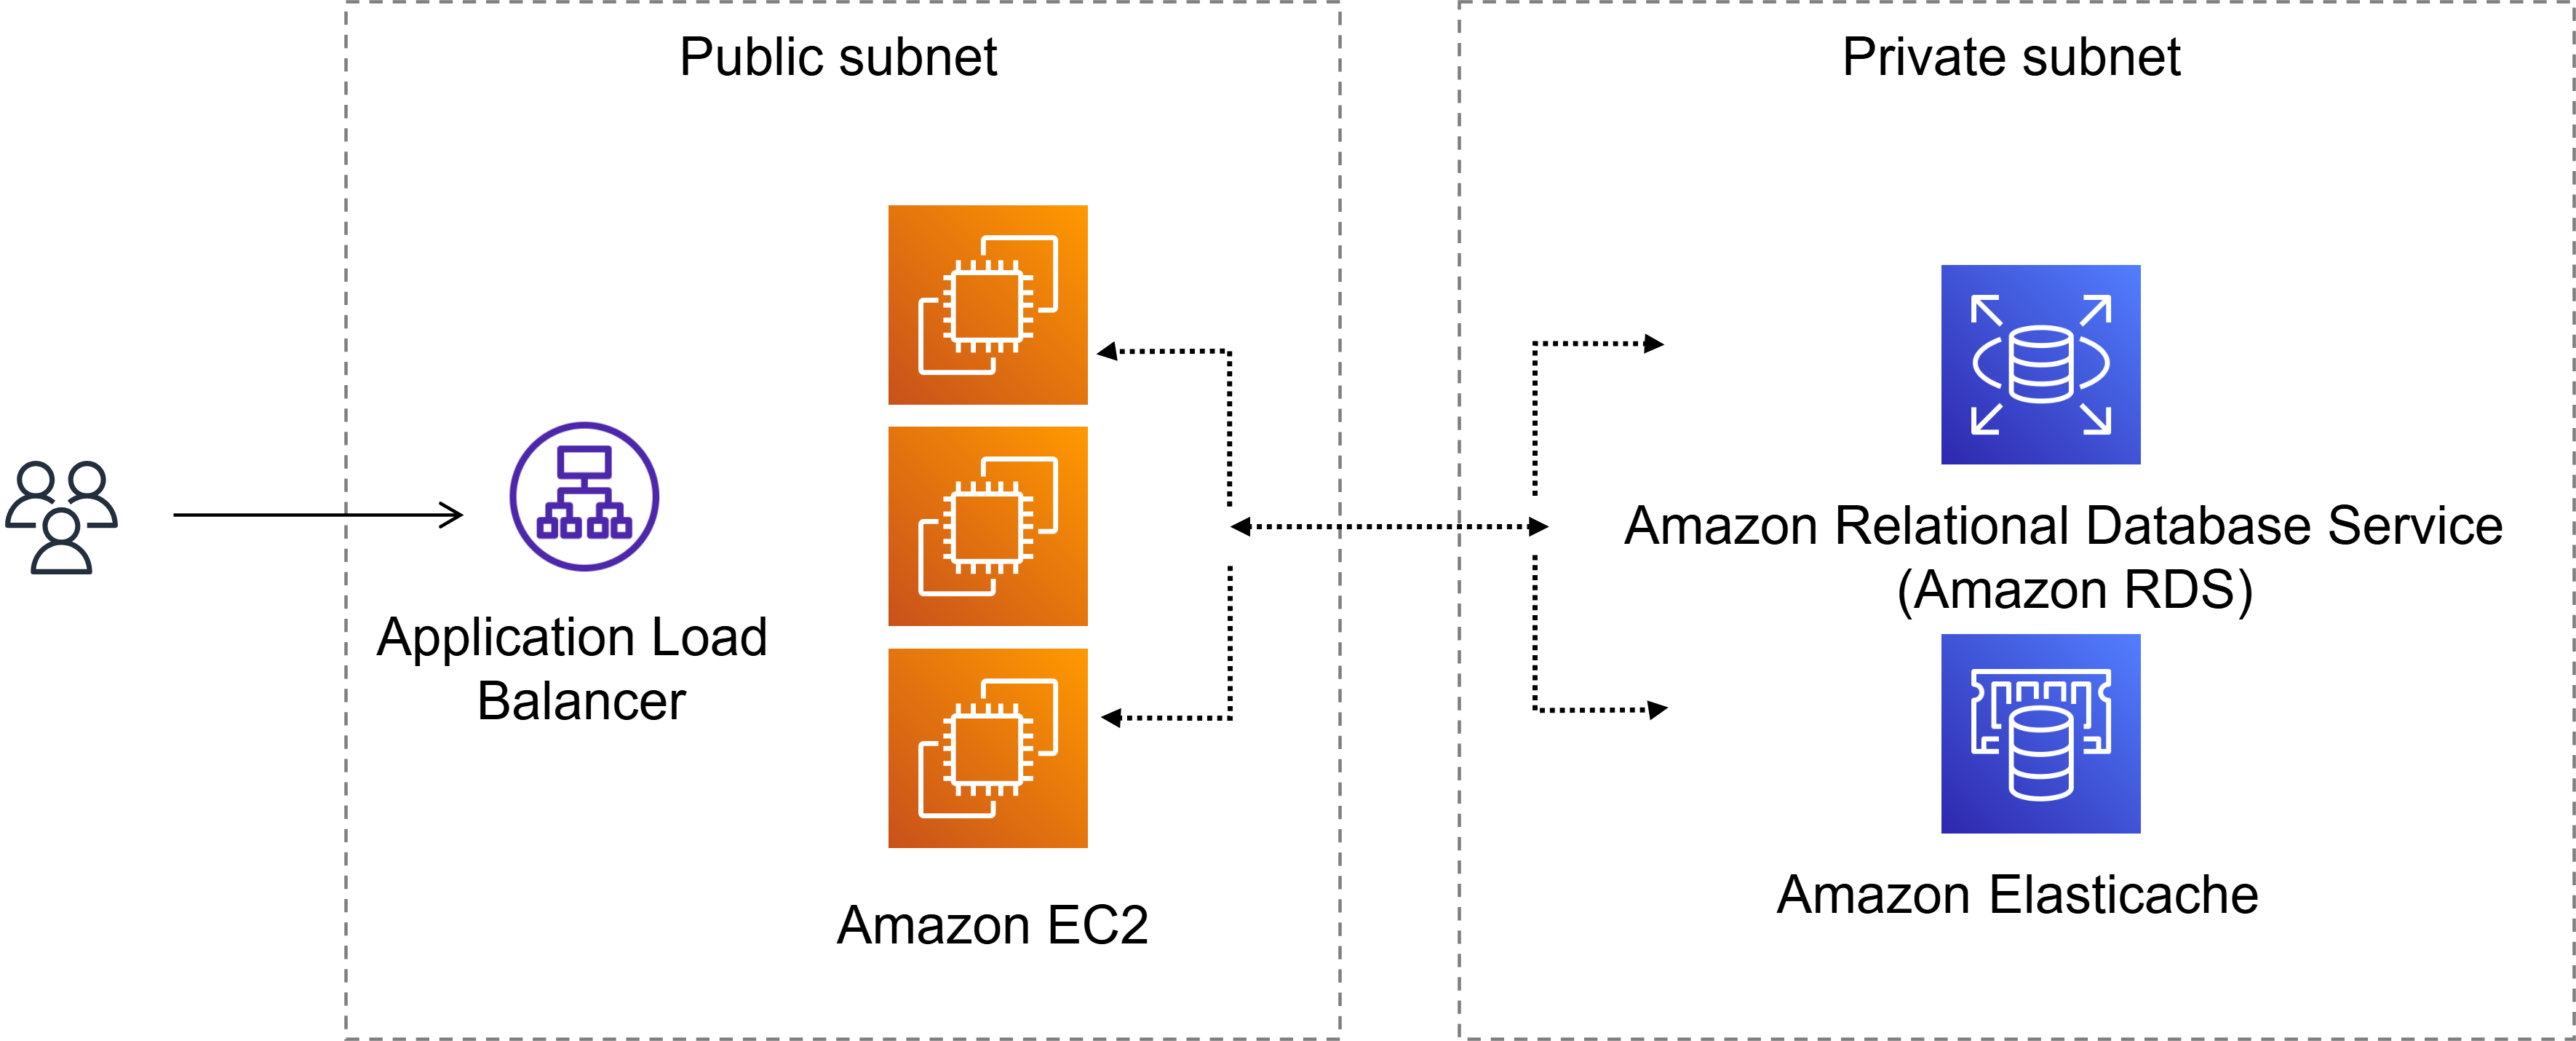

## Amazon EC2 service quotas

AWS has service quotas to protect you from unexpected excessive provisioning and malicious actions that might lead to an increase of your bill, and to protect the service endpoints. 

These limits can be managed using tools such as Limit Monitor and Service Quotas when using AWS Organizations. Limits apply in many different ways to all AWS services. Some can be raised; some are hard limits. 

Here are some examples specific to EC2:

- Number of vCPUs you can deploy – You can request a limit increase.
- Bandwidth limited based on instance type and size (no limit to transfer amount, only rate) – Changing instance type or size can increase bandwidth.
- Elastic IP limits – There is a soft limit of five per account.
- Elastic network interface and normal IP limits – Limits are locked to instance type and size.
- API call limits – Commands to describe or modify EC2 instances can be throttled.

John makes a note of the service quotas. He needs to ensure that he's properly allocating resources and monitoring his account service quotas so that all of his current and future needs are met.

The next objective on his list is to learn about the recovery options and recovery times for the various EC2 configuration options. He's curious to find out the fastest recovery options should he need to restore an instance if one is not highly available and resilient.